# Import library

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Atur seed
Seed diatur untuk reproduksibilitas

In [17]:
# ATUR SEED
def set_seed(seed=42):
    """Atur seed untuk reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Panggil fungsi ini di awal
set_seed(42)  

# Konfigurasi

In [18]:
# config
sequence_length = 1
num_epochs = 150
num_layers = 3
dropout = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import data

In [19]:
# import data
df = pd.read_csv(r"D:\Willy's Project\Project\16. Sentiment Analysis and Stock Forecasting\data\Data Ready.csv")
# df.head()

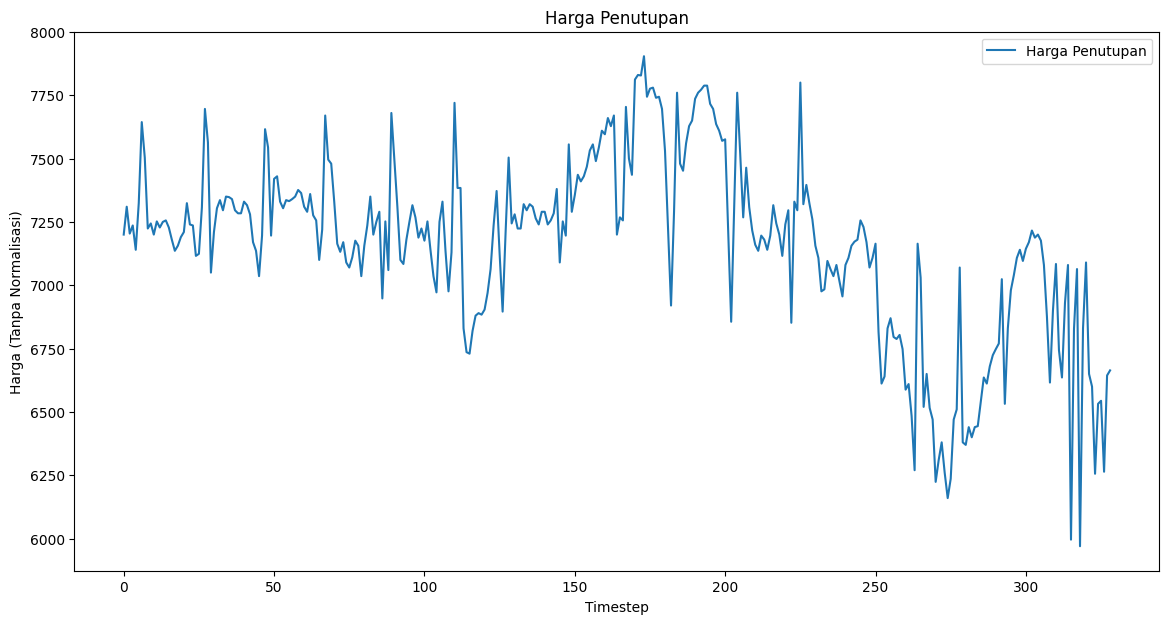

In [20]:
# visualisasi variabel penutupan
plt.figure(figsize=(14, 7))
plt.plot(df['Terakhir'], label='Harga Penutupan')
plt.title('Harga Penutupan')
plt.xlabel('Timestep')
plt.ylabel('Harga (Tanpa Normalisasi)')
plt.legend()
plt.show()

# Dataset & Data loader

In [21]:
# buat dataset
class StockDataset(Dataset):
    def __init__(self, df , sequence_length):
        self.sequence_length = sequence_length
        self.features = df[['Pembukaan', 'Tertinggi', 'Terendah', 'Sentiment_Score']].values
        self.labels = df['Terakhir'].values

    def __len__(self):
        return len(self.features) - self.sequence_length
    
    def __getitem__(self, idx):
        x = self.features[idx:idx+self.sequence_length]
        y = self.labels[idx+self.sequence_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Normalisasi data

In [22]:
# normalisasi data
scaler = MinMaxScaler()

df_scaled = df.copy()

df_scaled[['Pembukaan', 'Tertinggi', 'Terendah', 'Terakhir', 'Sentiment_Score']] = scaler.fit_transform(
    df_scaled[['Pembukaan', 'Tertinggi', 'Terendah', 'Terakhir', 'Sentiment_Score']])

In [24]:
# df_scaled.head()

# Persiapan dataset

In [25]:
# split train dan test
train_size = int(len(df_scaled) * 0.8)
df_train = df_scaled[:train_size]
df_test = df_scaled[train_size:]

In [26]:
# terapkan dataset
train_dataset = StockDataset(df_train, sequence_length)
test_dataset = StockDataset(df_test, sequence_length)

In [27]:
# dataloader
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Bangun model

Model LSTM

In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)        
        out = out[:, -1, :]          
        out = self.fc(out)
        return out.squeeze()

# Training loop

In [29]:
input_size = 4  
hidden_size = 64
learning_rate = 0.001

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_output = model(x_val)
            val_loss = criterion(val_output, y_val)
            val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(train_losses):.4f} - Test Loss: {np.mean(val_losses):.4f}")


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/150 - Train Loss: 0.4071 - Test Loss: 0.1147
Epoch 2/150 - Train Loss: 0.3262 - Test Loss: 0.0724
Epoch 3/150 - Train Loss: 0.2293 - Test Loss: 0.0310
Epoch 4/150 - Train Loss: 0.1094 - Test Loss: 0.0266
Epoch 5/150 - Train Loss: 0.0301 - Test Loss: 0.1224
Epoch 6/150 - Train Loss: 0.0262 - Test Loss: 0.0821
Epoch 7/150 - Train Loss: 0.0177 - Test Loss: 0.0502
Epoch 8/150 - Train Loss: 0.0203 - Test Loss: 0.0575
Epoch 9/150 - Train Loss: 0.0190 - Test Loss: 0.0717
Epoch 10/150 - Train Loss: 0.0181 - Test Loss: 0.0671
Epoch 11/150 - Train Loss: 0.0166 - Test Loss: 0.0600
Epoch 12/150 - Train Loss: 0.0178 - Test Loss: 0.0602
Epoch 13/150 - Train Loss: 0.0174 - Test Loss: 0.0593
Epoch 14/150 - Train Loss: 0.0165 - Test Loss: 0.0582
Epoch 15/150 - Train Loss: 0.0154 - Test Loss: 0.0571
Epoch 16/150 - Train Loss: 0.0164 - Test Loss: 0.0555
Epoch 17/150 - Train Loss: 0.0154 - Test Loss: 0.0540
Epoch 18/150 - Train Loss: 0.0163 - Test Loss: 0.0542
Epoch 19/150 - Train Loss: 0.0162 - T

# Prediksi/inferensi

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            output = model(x_test)
            
            output_np = output.cpu().numpy()
            y_test_np = y_test.numpy()
            
            if output_np.ndim == 0:
                output_np = np.array([output_np])
            if y_test_np.ndim == 0:
                y_test_np = np.array([y_test_np])
                
            predictions.extend(output_np)
            targets.extend(y_test_np)

    return predictions, targets


# Visualisasi

Test RMSE: 0.1746


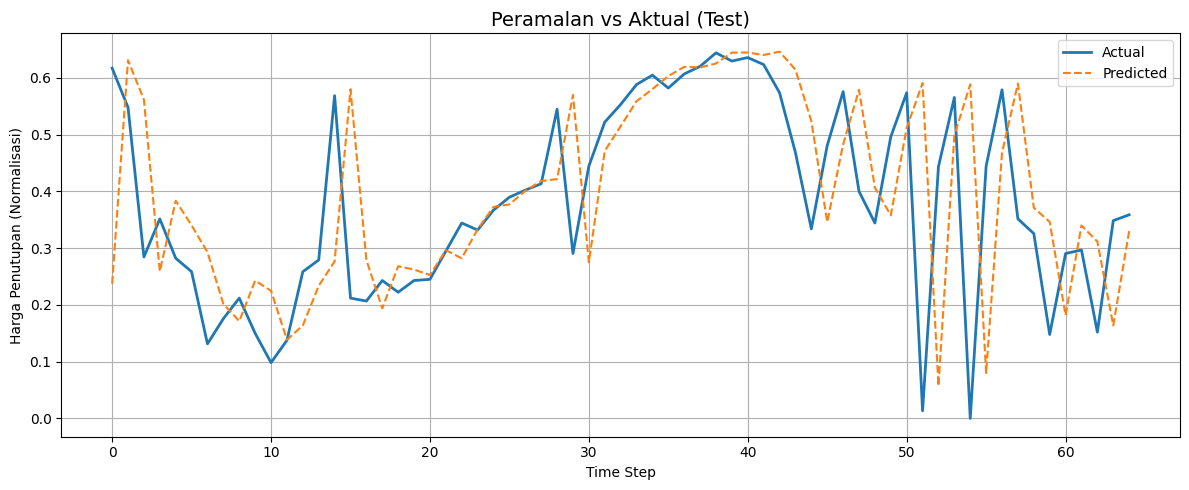

In [ ]:
# prediksi
preds, actuals = predict(model, test_loader, device)

# RMSE
rmse = np.sqrt(mean_squared_error(actuals, preds))
print(f"Test RMSE: {rmse:.4f}")

# visualisasi hasil prediksi vs aktual
plt.figure(figsize=(12, 5))
plt.plot(actuals, label='Actual', linewidth=2)
plt.plot(preds, label='Predicted', linestyle='--')
plt.title('Peramalan vs Aktual (Test)', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('Harga Penutupan (Normalisasi)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()